<a href="https://colab.research.google.com/github/szhou12/gpt-from-scratch/blob/main/gpt_dev_notes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GPT From Scratch
## Resources
- [Let's build GPT: from scratch, in code, spelled out.](https://www.youtube.com/watch?v=kCc8FmEb1nY&ab_channel=AndrejKarpathy)
- [Andrej Karpathy《从零开始搭建GPT|Let's build GPT from scratch, in code, spelled out》中英字](https://www.bilibili.com/video/BV1v4421c7fr/?spm_id_from=333.337.search-card.all.click&vd_source=0c02ef6f6e7a2b0959d7dd28e9e49da4)

In [ ]:
# We always start with a dataset to train on. Let's download the tiny shakespeare dataset
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2024-03-11 23:12:01--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt.1’

input.txt.1         100%[===================>]   1.06M  --.-KB/s    in 0.04s   

2024-03-11 23:12:01 (30.1 MB/s) - ‘input.txt.1’ saved [1115394/1115394]



In [ ]:
# read text data in to inspect it
with open('input.txt', 'r', encoding='utf-8') as f:
  text = f.read()

In [ ]:
print("length of dataset in characters: ", len(text))

length of dataset in characters:  1115394


In [ ]:
# let's look at the first 1,000 chars
print(text[:1000])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



In [ ]:
# Get all the unique characters that occur in the text
## set(text): make the set of all unique chars in text data
## list(...): to have some ordering so that we can sort it
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


## Tokenize [00:09:30]
- Tokenization: to convert the raw text as string into some sequences of integers according to some notebooks/rules/vocabularies of elements (字符串转换成数字序列的mapping过程).
- 下面给出的例子中, tokenization rule就是根据每个字符对应的index来进行编码.
- 常用的Tokenization方法:
  1. Byte-Pair Encoding (BPE)
    - [Byte-Pair Encoding tokenization - Hugging Face NLP Course](https://huggingface.co/learn/nlp-course/en/chapter6/5)
  2. SentencePiece by Google
  3. tiktoken by OpenAI
- One important Observation: trade-off between codebook size and sequence length.
  - The smaller the vobabulary size, the longer the sequences of integers.
    - e.g. character level vocab is small, so the encoded seq of ints will be long. (shown below)
  - The larger the vobabulary size, the shorter the sequences of integers.
    - e.g. sub-word level vocab is large, so the encoded seq of ints will be short.

In [ ]:
# create a mapping from characters to integers
stoi = {ch:i for i,ch in enumerate(chars)}
itos = {i:ch for i,ch in enumerate(chars)}
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

print(encode("hii there"))
print(decode(encode("hii there")))

[46, 47, 47, 1, 58, 46, 43, 56, 43]
hii there


In [ ]:
# let's now encode the entire text dataset and store it into a torch.Tensor
import torch
data = torch.tensor(encode(text), dtype=torch.long) # 1-D list
print(data.shape, data.dtype)
print(data[:1000]) # show first 1000 characters we looked at earlier

torch.Size([1115394]) torch.int64
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59,  1, 39, 56, 43,  1, 39, 50, 50,
         1, 56, 43, 57, 53, 50, 60, 43, 42,  1, 56, 39, 58, 46, 43, 56,  1, 58,
        53,  1, 42, 47, 43,  1, 58, 46, 39, 52,  1, 58, 53,  1, 44, 39, 51, 47,
        57, 46, 12,  0,  0, 13, 50, 50, 10,  0, 30, 43, 57, 53, 50, 60, 43, 42,
         8,  1, 56, 43, 57, 53, 50, 60, 43, 42,  8,  0,  0, 18, 47, 56, 57, 58,
         1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 18, 47, 56, 57, 58,  6,  1, 63,
        53, 59,  1, 49, 52, 53, 61,  1, 15, 39, 47, 59, 57,  1, 25, 39, 56, 41,
      

## Train & Test Split [00:13:42]

In [ ]:
# let's now split up the data into train and validation sets
n = int(0.9 * len(data)) # first 90% chars will be train, rest val
train_data = data[:n]
val_data = data[n:] # use val set to get a sense of overfitting

## Train On Chunks [00:14:28]
- **Important thing to notice**:
  1. we'll never feed the entire text into the transformer all at once because it's computationally expensive.
  2. We only feed chunks of the text.
  3. Ramdomly sampling chunks from the text dataset and train on a chunk at a time.
  4. These chunks will be pre-set with max length (normally called `block_size` or `context_length`).

In [ ]:
# set block_size = 8
block_size = 8
train_data[:block_size+1] # first 9 chars. Do you understand why 9 intead of 8?

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58])

- How many training examples are there in this sequence of integers of length=9?
  - 8 examples!!!
   - Because to predict `i`-th position's char (called "target"), we need to use all `[0:i-1]` positions' chars (called "context"). i.e. one example = `[0:i-1]` predict `[i]`
  - [18] predicts 47, [18, 47] predict 56, [18, 47, 56] predict 58, ...
  - The code below illustrate this concept:

In [ ]:
x = train_data[:block_size]
y = train_data[1:block_size+1]
for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print(f"Round {t}: when input (aka. context) is {context}, the target: {target}")

Round 0: when input (aka. context) is tensor([18]), the target: 47
Round 1: when input (aka. context) is tensor([18, 47]), the target: 56
Round 2: when input (aka. context) is tensor([18, 47, 56]), the target: 57
Round 3: when input (aka. context) is tensor([18, 47, 56, 57]), the target: 58
Round 4: when input (aka. context) is tensor([18, 47, 56, 57, 58]), the target: 1
Round 5: when input (aka. context) is tensor([18, 47, 56, 57, 58,  1]), the target: 15
Round 6: when input (aka. context) is tensor([18, 47, 56, 57, 58,  1, 15]), the target: 47
Round 7: when input (aka. context) is tensor([18, 47, 56, 57, 58,  1, 15, 47]), the target: 58


- **One More Important Thing**
  - Why, for a given block size (=8 in this exmaple), we train from context length of 1 all the way up to context length of block_size (=8)?
  - Not only for computational efficiency;
  - But in order for the transformer to be used to seeing context from as little as length 1 all the way to block size. That is, we want the transformer to be used to all these context lengths (1, 2, 3, ..., 8).
    - Why? Because doing so is useful for later inference.
    - How so? Because while we start sampling, we can start the sampling generation with context length = 1. The transformer will know how to predict in this situation. Similarly, the transformer will how how to predict in the situation of context length = `2, 3, ..., block_size`.
    - 简言之，让模型习惯应对任意长度(`1,2,3, ..., block_size`)的输入情况下的预测。

## Batch dimension [00:18:07]
- Notice that, so far, the tensor is 1-D (call it "time dimension").
- Now onto batch dimension! Every time of sampling, we retreive a batch of chunks instead of one chunk, and feed this batch (multiple chunks) into the transformer all at once at the same time.
- Why? Mainly for computational efficiency. Because GPU is good at parallel processing of data.
- But notice! Each chunk from the batch is processed independently! They don't talk to each other!

In [ ]:
torch.manual_seed(1337)
batch_size = 4 # how many independent sequences will we parallelly process in every forward-backward pass in the transformer?
block_size = 8 # what is the maximum context length for predictions?

def get_batch(split):
    # generate a small batch of data of inputs X and targets y
    data = train_data if split == "train" else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,)) # 从[0, n-block_size)中随机抽4个数，返回长度为4的list [a, b, c, d]. (batch_size=4,)输出1-D list
    x = torch.stack([data[i:i+block_size] for i in ix]) # X
    y = torch.stack([data[i+1:i+block_size+1] for i in ix]) # true y - used to calculate loss y - y_hat
    return x, y

xb, yb = get_batch('train')
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)
print('----')

for b in range(batch_size):
    for t in range(block_size):
        context = xb[b, :t+1]
        target = yb[b, t]
        print(f"when input is {context.tolist()} the target: {target}")

inputs:
torch.Size([4, 8])
tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])
targets:
torch.Size([4, 8])
tensor([[43, 58,  5, 57,  1, 46, 43, 39],
        [53, 56,  1, 58, 46, 39, 58,  1],
        [58,  1, 58, 46, 39, 58,  1, 46],
        [17, 27, 10,  0, 21,  1, 54, 39]])
----
when input is [24] the target: 43
when input is [24, 43] the target: 58
when input is [24, 43, 58] the target: 5
when input is [24, 43, 58, 5] the target: 57
when input is [24, 43, 58, 5, 57] the target: 1
when input is [24, 43, 58, 5, 57, 1] the target: 46
when input is [24, 43, 58, 5, 57, 1, 46] the target: 43
when input is [24, 43, 58, 5, 57, 1, 46, 43] the target: 39
when input is [44] the target: 53
when input is [44, 53] the target: 56
when input is [44, 53, 56] the target: 1
when input is [44, 53, 56, 1] the target: 58
when input is [44, 53, 56, 1, 58] the target: 46
when input is [44, 53

## Feeding Data to Neural Network - Bigram Language Model [00:22:14]
- Start with a simple neural network: Bi-gram language model (details in his previous courses)

### Pytorch Recap
1. `import torch.nn as nn`
    - The `torch.nn` module contains classes and functions that are used for building neural networks in PyTorch. This includes the foundational building blocks for neural networks, such as layers (e.g., `Linear`, `Conv2d`), and modules (`Module`), which are the base class for all neural network modules.
    - `nn` (Object-oriented API): Provides classes that allow you to encapsulate parameters and helpers in objects. This is useful for defining complex models and is typically preferred when designing architectures.
2. `from torch.nn import functional as F`
    - The `torch.nn.functional` module contains function versions of many of the operations and layers available in `torch.nn`.
    - These functions include activation functions (`F.relu`, `F.sigmoid`), operations used in convolutional neural networks (`F.conv2d`, `F.max_pool2d`), and loss functions (`F.cross_entropy`), among others.
    - Unlike the classes in `torch.nn`, which require creating an instance of the class (e.g., `layer = nn.Conv2d(...)`), functions in `torch.nn.functional` can be used directly by passing inputs and any necessary parameters (e.g., `output = F.conv2d(input, weight)`).
    - `F` (Functional API): Provides stateless, functional alternatives to the classes in `nn`. This is useful for operations that don't require storing state (parameters), such as applying activations, performing a convolution operation with dynamically created filters, or applying a loss function directly within the model's forward method.
3. `nn.Embedding`
    - A PyTorch layer that's typically used to convert token indices in a vocabulary into dense vector representations (embeddings). The layer takes two main arguments: **(the number of embeddings, the dimensionality of each embedding vector)**. In most natural language processing (NLP) tasks, the dimensionality of embeddings is much smaller than the vocabulary size, facilitating efficient representation of words or tokens.
    - Assume `vocab_size=65`, This layer (`self.token_embedding_table`) now acts as a 65x65 table where **each row corresponds to a token** and **each column to a possible next token**, **with values being the logits** (raw predictions prior to normalization).
    - When you input an index (or indices) to this layer, it returns the corresponding row(s) (aka. channel) from the table. For instance, if the input index is 3 (for `a`), the layer returns the 4th row (0-indexed) of the table, which is a vector of size 65. Each element of this vector represents the model's logit for the probability of each vocabulary token being the next token after `a`.
4. Why Use Cross-Entropy For Loss?
    - Recall cross-entropy measures the difference between two probability distributions.

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)

class BigramLanguageModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        # each token direclty reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

    def forward(self, idx, targets=None):
        '''
        idx: (B,T) tensor of integer. data. xb from previous cell
        targets (Optional): (B,T) tensor of integer. true y. yb from previous cell. Make it optional as generate() won't use loss.
        '''

        # idx and targets are both (B, T) tensor of integers
        # 相当于, 根据idx对应的输入抽出所有下一个token可能出现的概率, 所有下一个token称为channel, 长度为vocab_size
        logits = self.token_embedding_table(idx) # (B,T,C) = (batch, time, channel/class=vocab_size)

        if targets is None:
            loss = None
        else:
            # 进行维度的转换，因为Pytorch中cross_entropy()的第二个param只能接收C, 保留原来的(B,T,C)会报错
            B, T, C = logits.shape
            logits = logits.view(B*T, C) # squash first 2 dims into 1 dim, keep the 3rd dim
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        '''
        idx: (B, T) array of indices in the current context.
            Note! indices meant here are integer representations of chars, so essentially idx are data (context) we feed
        max_new_tokens: # of new tokens to be predicted and appended to idx
        '''
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # get the predictions (logits)
            logits, loss = self(idx) # self(idx) calls forward()

            # focus only on the last time step
            # -1意味着我们现在只在意用8个token一起predict的那个example
            # 注意: logits[:, i, :] ith位子上的logit表示用前i个token一起predict下一个可能出现的token
            # e.g. 1st logit是只用第一个token predict的结果, 2nd logit是用头两个token predict的结果, 依此类推.
            # -1表示最后一个位子上的logit, 用了所有前面能用到的token
            # !!!上面的理解错了!!!
            # Bigram model中: -1意味着我们现在只用最后一个token来predict下一个token, 没有用到再往前的tokens!
            # 注意: logits[:, i, :] ith位子上的logit表示用第i个token来predict下一个可能出现的token
            # e.g. 1st logit是只用第一个token predict的结果, 2nd logit只用第二个token predict的结果, 依此类推.
            # -1表示最后一个位子上的logit, 只用了所有最后一个token
            logits = logits[:, -1, :] # becomes (B, C)

            # apply softmax to get the probablities
            # dim=-1: 沿着last dimension of logits (ie. C)计算softmax score
            # 每条data, 横向地沿着所有classes计算softmax. 这样，batch中每一条data都独立计算
            probs = F.softmax(logits, dim=-1) # (B, C)

            # sample from the distribution
            # 每条data, 根据class probabilities随机采样一个class.
            # e.g. 假设一条data的probability: [0.1, 0.2, 0.5, 0.3], multinomial根据每个class的概率大小抽一个class (num_samples=1)
            # 显然, i=2的元素最容易抽到因为它的概率最高=0.5
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)

            # append sampled index to the running sequence
            # dim=1 沿着第二个dimension (sequence length dimension)，一列一列地append新的采样到的data
            # [[24, 43], -> [[24, 43, 58],
            #  [52, 58]] ->  [52, 58,  1]]
            # 注意！这里可以直接append index, 是因为tokenization是index直接对应char. 如果是其他tokenize方法, 可能需要额外转换index对应的元素
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)

        return idx



# 1. instantiate BigramLanguageModel class;
# 2. init token_embedding_table as an embedding layer, with logits randomly generated
m = BigramLanguageModel(vocab_size)

logits, loss = m(xb, yb)
print(logits.shape)
print(loss)

# Given [[0]] (1 batch, 1 time step), sequentially generate 100 tokens after first token: [[0]] -> [[0, 1]] -> [[0, 1, 3]] -> ...
# Remember, in this case, each token newly generated uses ONLY ONE token generated ahead of it. NO HISTORY USED HERE! Can you recall why?
# [0].tolist(): take out the content of the first data from the batch and convert it to list
print(decode(m.generate(idx = torch.zeros((1,1), dtype=torch.long), max_new_tokens=100)[0].tolist()))

NameError: name 'vocab_size' is not defined

## Train The Bigram Language Model [0:34:50]



1. `AdamW`: A variant of the Adam optimizer that decouples the weight decay from the optimization steps. Currently a popular choice of optimizer.
2. `lr=1e-3`: Typically, a good learning rate = `3e-4`. But if you're using small models, you can use higher learning rate.

In [ ]:
# create a PyTorch optimizer
##
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)

The code below provides a template of training:
1. `optimizer.zero_grad(set_to_none=True)`: **Zeroing the Gradients**. Clear out the gradients from the previous training step before using optimizer to update the model parameters by this round's gradients. In Pytorch, the gradients are accumulated through training steps!
    - `set_to_none=True`: aims to improve the speed of setting gradients to zero. Traditional way is `optimizer.zero_grad()`, which iterates through all model params' `.grad` attributes and set to zero. Instead of filling zeros, `set_to_none=True` sets `.grad` to `None`. Two advantages: 1) It reduces memory usage 因为不需要内存来暂时储存0. 2) It can potentially speed up gradient zeroing 因为设为None比填充0快一些
2. `loss.backward()`: computes the gradient of the loss w.r.t the model parameters using backpropagation.
3. `optimizer.step()`: updates the model parameters based on the gradients calculated. Update rule depends on the optimizer choice (In this case is `AdamW`).
4. `loss.item()`: `.item()` method converts the loss from a tensor to a Python scalar.

In [ ]:
batch_size = 32

iters = 100 # increase # of steps for better results
for steps in range(iters):
    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = m(xb, yb) # Forward pass + Loss
    optimizer.zero_grad(set_to_none=True) # clear out previous gradient
    loss.backward() # Gradient
    optimizer.step() # Update w

print(loss.item())

4.587916374206543


### Demo of Typical Training Process
- Model: a very simple neural network on a regression task $y = wx + b$.
- Parameters: $w$ and $b$ (bias). Initially, $w=0$, $b=0$. Assume $b=0$ throughout the training.
- Loss Function: $L = (y-\widehat{y})^{2}$ (MSE)
- Learning Rate: $lr = 0.01$
- Dataset: $(x_1=2, y_1=4)$, $(x_2=3, y_2=6)$

1. First step of training using $(x_1=2, y_1=4)$:
    1. Forward pass: $\widehat{y_1} = w⋅x_1 = 0⋅2 = 0$
    2. Loss: $L_1 = (y_1-\widehat{y_1})^{2} = (4-0)^2 = 16$
    3. Gradient: $\frac{dL_1}{dw} = 2⋅(y_1-\widehat{y_1})⋅(-x_1) = 2⋅(4-0)\cdot(-2) = -16$
    4. Update $w$: $w=w-lr⋅\frac{dL_1}{dw} = 0-0.01⋅(-16)=0.16$
2. Second step of training using $(x_2=3, y_2=6)$:
    1. Forward pass: $\widehat{y_2} = w⋅x_2 = 0.16⋅3 = 0.48$
    2. Loss: $L_2 = (y_2-\widehat{y_2})^{2} = (6-0.48)^2$
    3. Gradient: $\frac{dL_2}{dw} = 2⋅(y_2-\widehat{y_2})⋅(-x_2) = 2⋅(6-0.48)⋅(-3) = -33.12$
        - Note: here we clear out step 1's gradient so that we use  $\frac{dL_2}{dw}$ instead of $\frac{dL_2}{dw}+\frac{dL_1}{dw}$!!!
    4. Update $w$: $w=w-lr⋅\frac{dL_2}{dw} = 0.16-0.01⋅(-33.12)=0.4912$

### Recap: Geometric Meaning of Gradient Descent
- Why do we take minus? $w' = w - lr\cdot \frac{dL}{dw}$
    - Because a gradient means the direction of the steepest **increase** of the loss function, we take the opposite value of the gradient to minimize the loss.

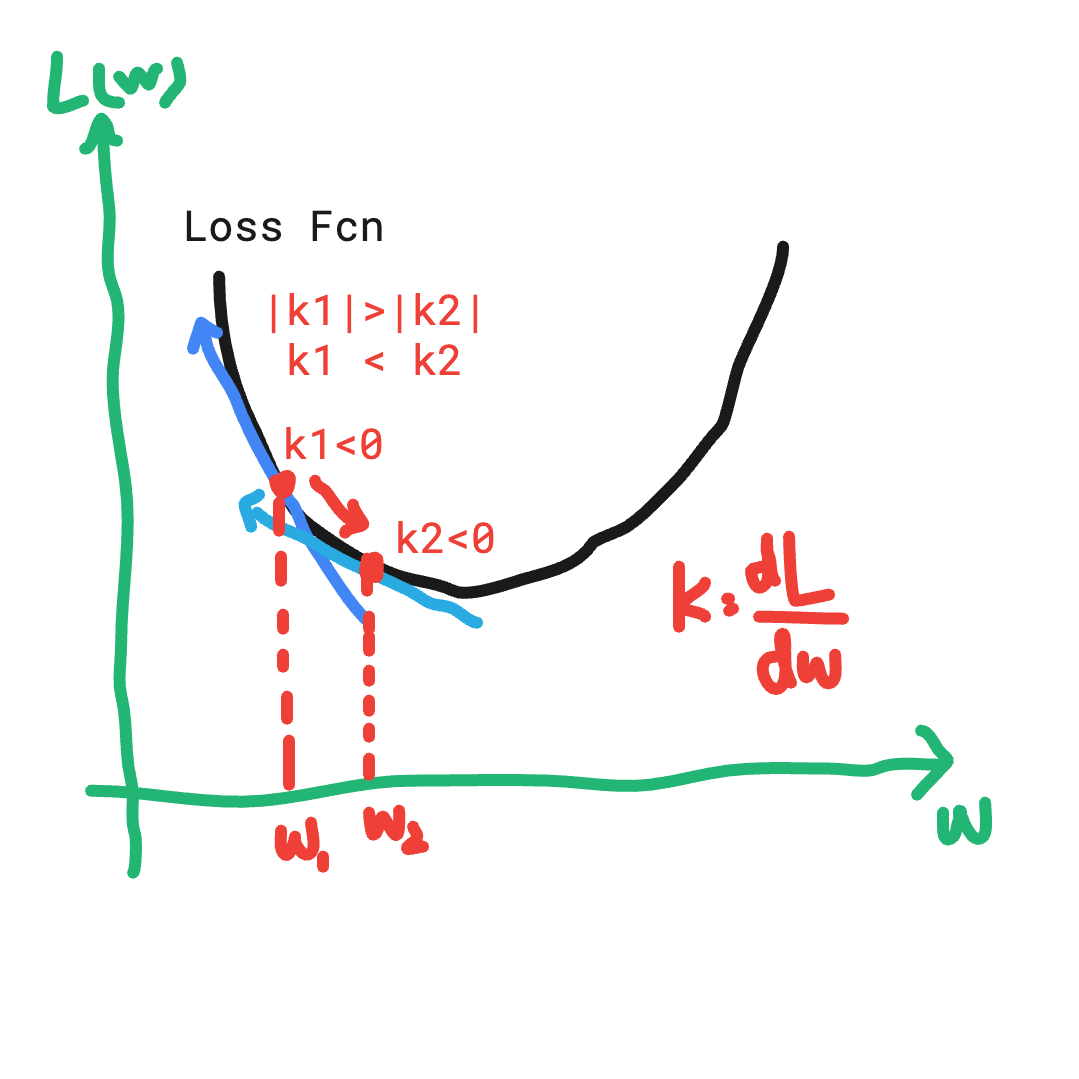

In [ ]:
print(decode(m.generate(idx = torch.zeros((1, 1), dtype=torch.long), max_new_tokens=500)[0].tolist()))


xiKi-RJ:CgqVuUa!U?qMH.uk!sCuMXvv!CJFfx;LgRyJknOEti.?I&-gPlLyulId?XlaInQ'q,lT$
3Q&sGlvHQ?mqSq-eON
x?SP fUAfCAuCX:bOlgiRQWN:Mphaw
tRLKuYXEaAXxrcq-gCUzeh3w!AcyaylgYWjmJM?Uzw:inaY,:C&OECW:vmGGJAn3onAuMgia!ms$Vb q-gCOcPcUhOnxJGUGSPJWT:.?ujmJFoiNL&A'DxY,prZ?qdT;hoo'dHooXXlxf'WkHK&u3Q?rqUi.kz;?Yx?C&u3Qbfzxlyh'Vl:zyxjKXgC?
lv'QKFiBeviNxO'm!Upm$srm&TqViqiBD3HBP!juEOpmZJyF$Fwfy!PlvWPFC
&WDdP!Ko,px
x
tREOE;AJ.BeXkylOVD3KHp$e?nD,.SFbWWI'ubcL!q-tU;aXmJ&uGXHxJXI&Z!gHRpajj;l.
pTErIBjx;JKIgoCnLGXrJSP!AU-AcbczR?


## Put All Above Into `bigram.py` [00:38:00] With 2 Updates
1. Additional code to run on GPU device
2. Introduce `estimate_loss()` to average out noisy loss resulted from randomly sampled batches (some batch lucky, some not). [00:39:40]

## Math Trick in Self-Attention [00:42:14]
- An efficient implementation of self-attention.
- Previously, tokens (T) are NOT communicating with each other. Here, we want them communicate.
- However, one token should only talk to previous tokens, not to future tokens. e.g., 5th token should ONLY talk to 1st, ..., 4th tokens but not to 6th, ..., 8th tokens. This is because we want to predict the future.
- How to communicate?
    - For a time `i=t`, **average** the values (logits) along each channel `c` from `i=0,...,t` (including `t` itself)
    - The average value serves as a feature vecor that summarizes 'me' in the context of my history.
    - Note! sum/average is a lossy communication. We will lose info of spatial arrangements of these tokens. But it will work for now! We'll bring back spatial info back later.

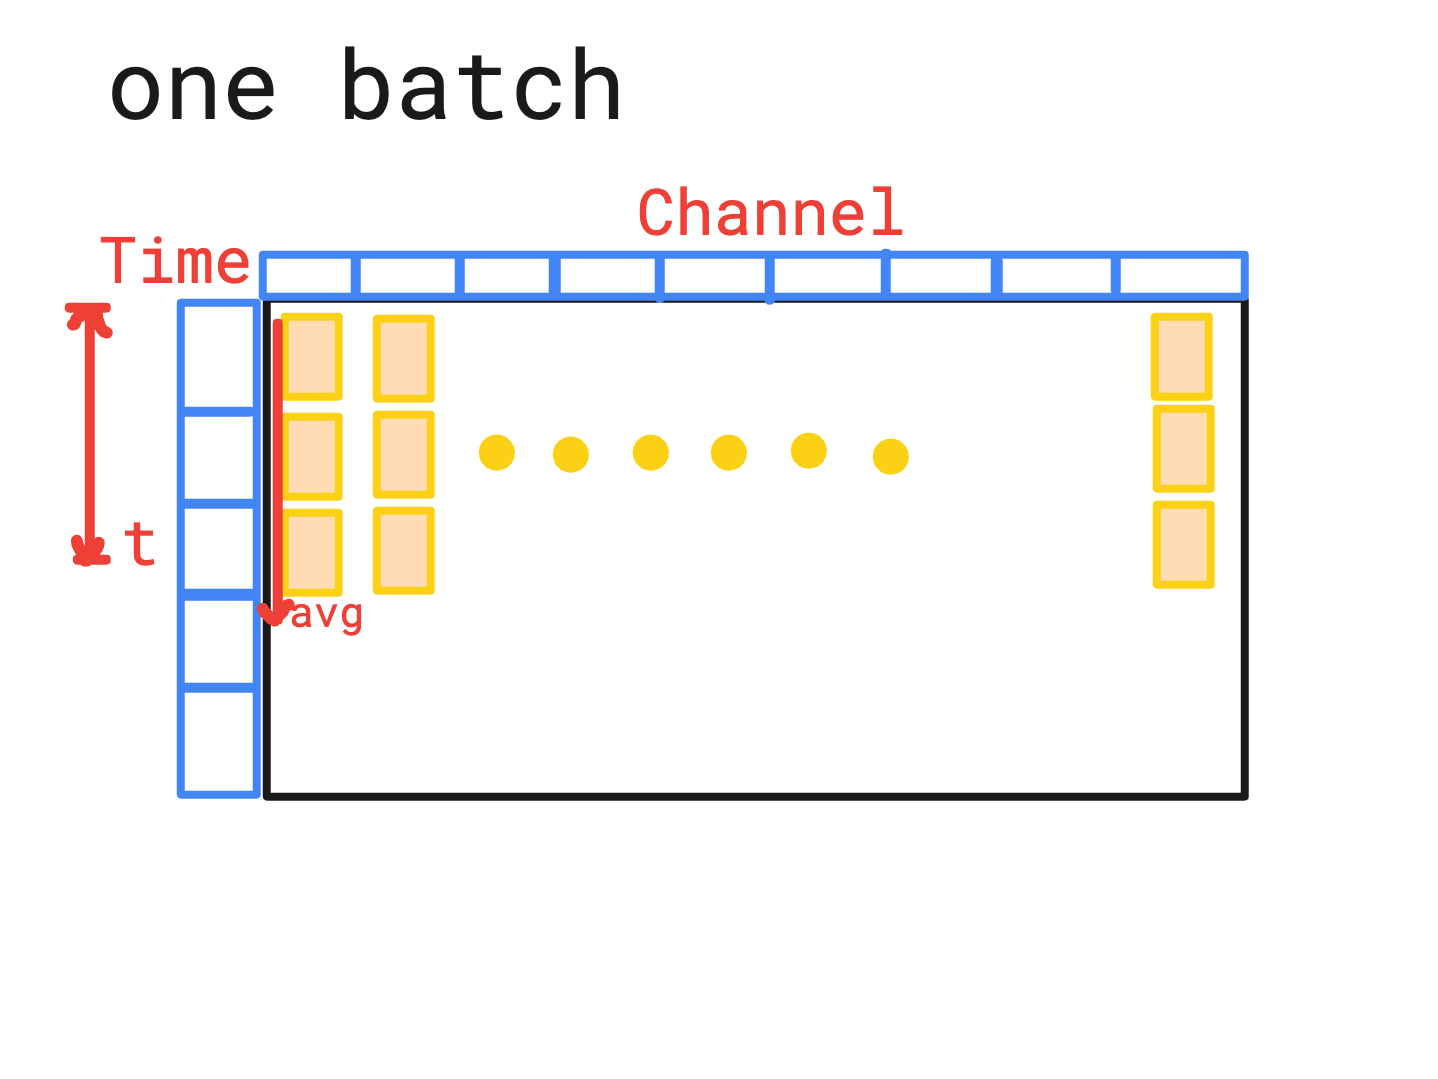

In [ ]:
# Consider the following toy example
torch.manual_seed(1337)
B, T, C = 4, 8, 2 # batch, time, channels
x = torch.randn(B,T,C)
x.shape

torch.Size([4, 8, 2])

### Averaging Version 1 - Iterative

In [ ]:
# We want x[b,t] = mean_{i<=t} x[b,i]
# Let's do the averaging in iterative way (inefficient!)
xbow = torch.zeros((B,T,C)) # bow = bag of words - term that people use to average up things
for b in range(B): # given a batch
    for t in range(T):
        xprev = x[b,:t+1] # (t, C)
        xbow[b,t] = torch.mean(xprev, 0) # average out along t - squash i=0,...,t for each c

In [ ]:
x[0]

tensor([[ 0.1808, -0.0700],
        [-0.3596, -0.9152],
        [ 0.6258,  0.0255],
        [ 0.9545,  0.0643],
        [ 0.3612,  1.1679],
        [-1.3499, -0.5102],
        [ 0.2360, -0.2398],
        [-0.9211,  1.5433]])

In [ ]:
# -0.0894 = (0.1808 + -0.3596)/2
# 0.1490 = (0.1808 + -0.3596 + 0.6258)/3
xbow[0]

tensor([[ 0.1808, -0.0700],
        [-0.0894, -0.4926],
        [ 0.1490, -0.3199],
        [ 0.3504, -0.2238],
        [ 0.3525,  0.0545],
        [ 0.0688, -0.0396],
        [ 0.0927, -0.0682],
        [-0.0341,  0.1332]])

**Here Comes The Trick! Step 1**
- Here, each cell of C is the sum of corresponding column of B:
- $C_{t1} = \sum_{i=1}^3 B_{i1}$ where $t=1,\cdots,3$
- $C_{t2} = \sum_{i=1}^3 B_{i2}$ where $t=1,\cdots,3$

In [ ]:
torch.manual_seed(42)
a = torch.ones(3,3) # matrix (3X3)
b = torch.randint(0,10,(3,2)).float() # matrix (3X2), each with random val (0~9)
c = a @ b # matrix (3X2)
print('a=')
print(a)
print('--')
print('b=')
print(b)
print('--')
print('c=')
print(c)

a=
tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])
--
b=
tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])
--
c=
tensor([[14., 16.],
        [14., 16.],
        [14., 16.]])


**magic function**: `torch.tril(X)`
- returns the lower triangular portion of the input matrix `X`. Upper triangular portion becomes 0.

In [ ]:
# magic function: torch.tril()
torch.tril(torch.ones(4,4))

tensor([[1., 0., 0., 0.],
        [1., 1., 0., 0.],
        [1., 1., 1., 0.],
        [1., 1., 1., 1.]])

**Here Comes The Trick! Step 2**
- Here, each cell of C becomes the accumulated sum of corresponding column of B:
- $C_{t1} = \sum_{i=1}^t B_{i1}$ where $t=1,\cdots,3$
- $C_{t2} = \sum_{i=1}^t B_{i2}$ where $t=1,\cdots,3$

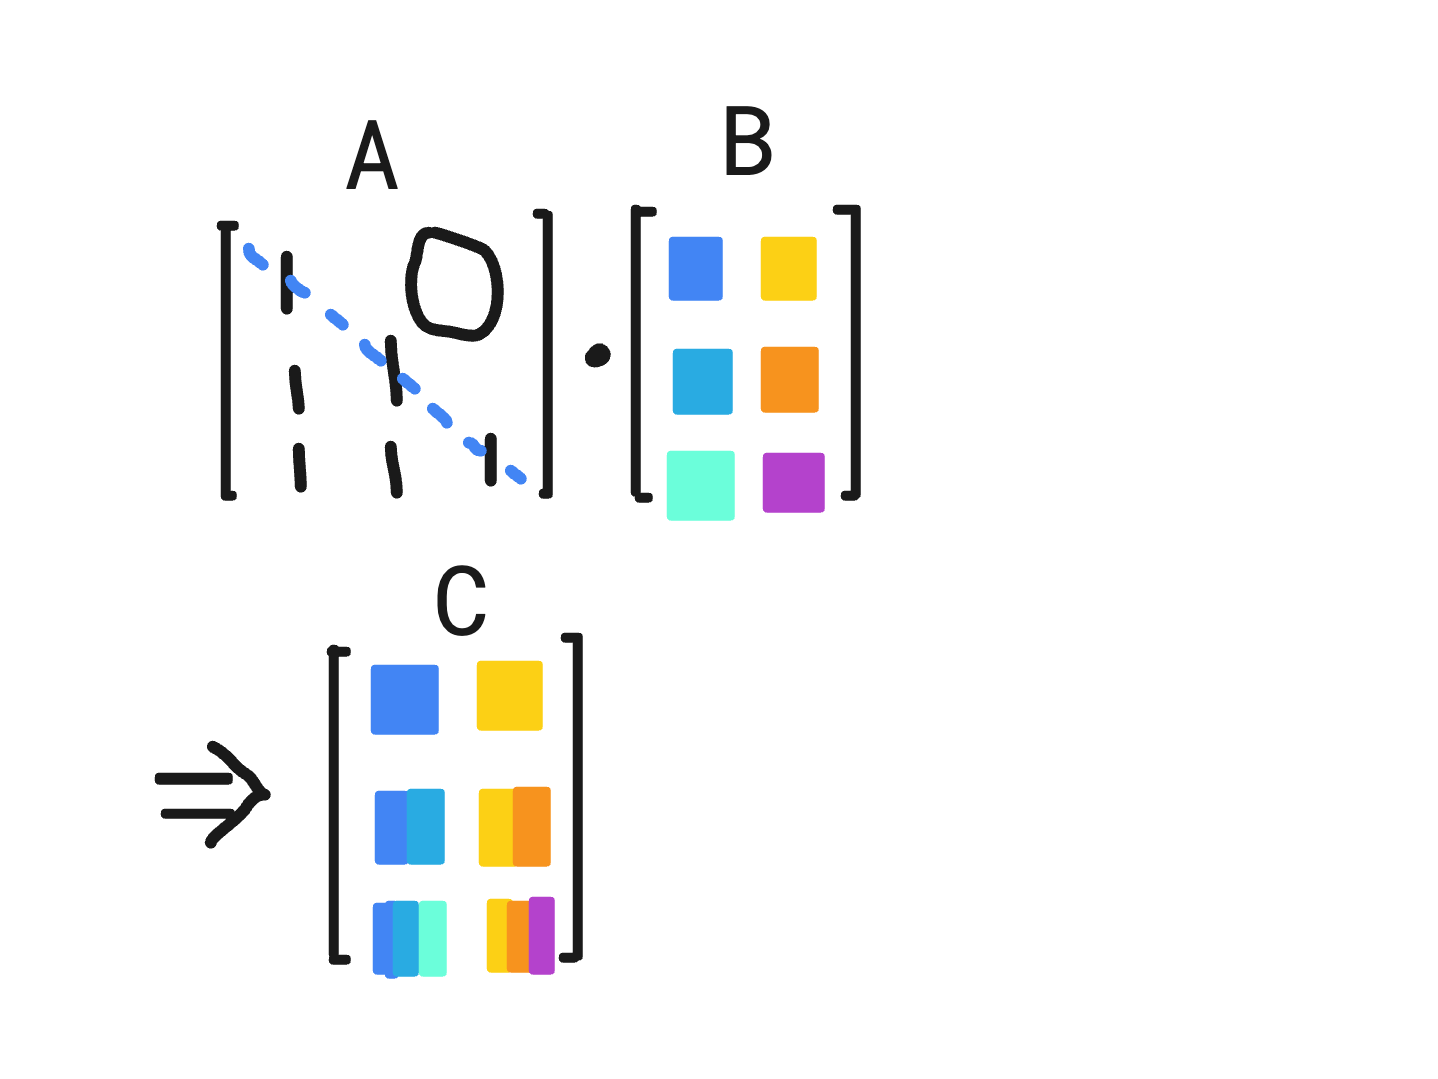

In [ ]:
torch.manual_seed(42)
a = torch.tril(torch.ones(3,3)) # Use tril() for a -> lower triangular matrix (3X3)
b = torch.randint(0,10,(3,2)).float() # matrix (3X2), each with random val (0~9)
c = a @ b # matrix (3X2)
print('a=')
print(a)
print('--')
print('b=')
print(b)
print('--')
print('c=')
print(c)

a=
tensor([[1., 0., 0.],
        [1., 1., 0.],
        [1., 1., 1.]])
--
b=
tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])
--
c=
tensor([[ 2.,  7.],
        [ 8., 11.],
        [14., 16.]])


**Here Comes The Trick! Step 3**
- Here, each cell of C becomes the **average** of accumulated sum of corresponding column of B:
- $C_{t1} = \frac{1}{t} \sum_{i=1}^t B_{i1}$ where $t=1,\cdots,3$
- $C_{t2} = \frac{1}{t} \sum_{i=1}^t B_{i2}$ where $t=1,\cdots,3$

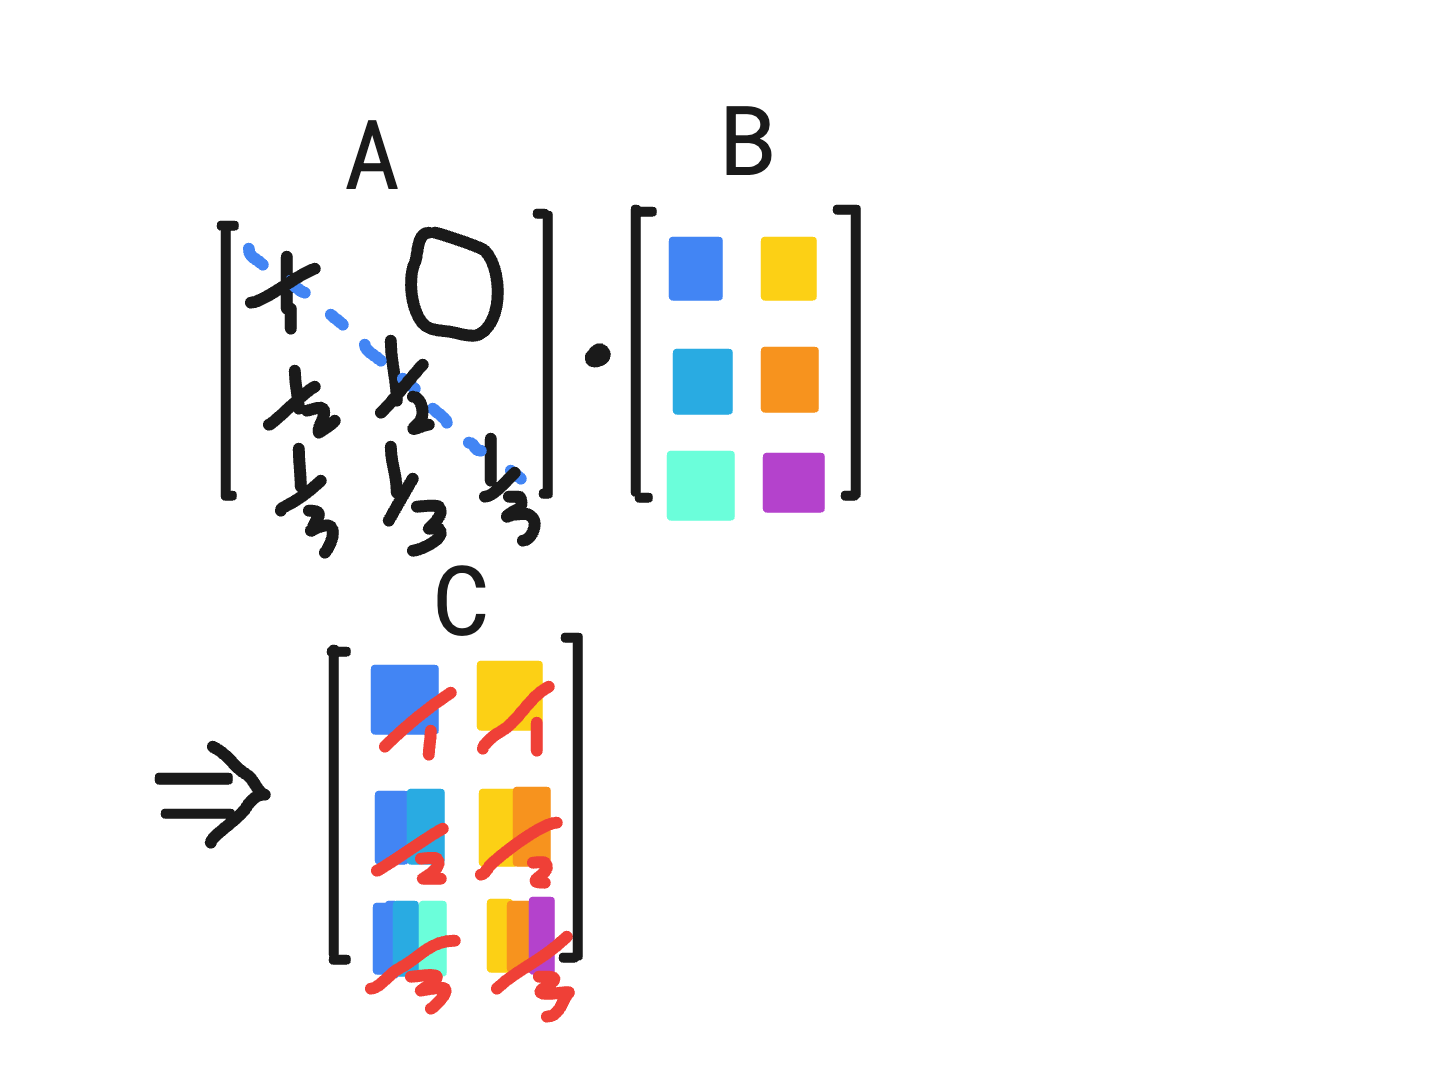

In [ ]:
torch.manual_seed(42)
a = torch.tril(torch.ones(3,3)) # Use tril() for a -> lower triangular matrix (3X3)
a = a / torch.sum(a, 1, keepdim=True) # sum(a, 1, keepdim=True) = sum each row of a (1 means along row direction) -> A=avg matrix. a1 = [1, 1/2, 1/3]
b = torch.randint(0,10,(3,2)).float() # matrix (3X2), each with random val (0~9)
c = a @ b # matrix (3X2)
print('a=')
print(a)
print('--')
print('b=')
print(b)
print('--')
print('c=')
print(c)

a=
tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])
--
b=
tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])
--
c=
tensor([[2.0000, 7.0000],
        [4.0000, 5.5000],
        [4.6667, 5.3333]])


### Averaging Version 2 - Matrix Multiplication
- **Now Time To Put All 3 Steps Together!**
- Keys to remember:
    1. `torch.tril(X)`
    2. `X / X.sum(1, keepdim=True)`


In [ ]:
# Consider the following toy example
torch.manual_seed(1337)
B, T, C = 4, 8, 2 # batch, time, channels
x = torch.randn(B,T,C)
x.shape

torch.Size([4, 8, 2])

In [ ]:
# wei = A, x = B
wei = torch.tril(torch.ones(T, T))
wei = wei / wei.sum(1, keepdim=True)
# Pytorch detects the dim of wei and x don't match up, it will firstly pad with batch dimension (B) for wei. B number of copies of wei.
# Then apply matrix multi
xbow2 = wei @ x # (T, T) @ (B, T, C) --> (B, T, T) @ (B, T, C) --> (B, T, C)
torch.allclose(xbow, xbow2, atol=1e-07)

True

In [ ]:
xbow2[1]

tensor([[ 1.3488, -0.1396],
        [ 0.8173,  0.4127],
        [-0.1342,  0.4395],
        [ 0.2711,  0.4774],
        [ 0.2421,  0.0694],
        [ 0.0084,  0.0020],
        [ 0.0712, -0.1128],
        [ 0.2527,  0.2149]])

In [ ]:
xbow[1]

tensor([[ 1.3488, -0.1396],
        [ 0.8173,  0.4127],
        [-0.1342,  0.4395],
        [ 0.2711,  0.4774],
        [ 0.2421,  0.0694],
        [ 0.0084,  0.0020],
        [ 0.0712, -0.1128],
        [ 0.2527,  0.2149]])

### Averaging Version 3 - Matrix Multiplication Using Softmax
```
tril = torch.tril(torch.ones(T, T))
wei = torch.zeros((T, T))
wei = wei.masked_fill(tril==0, float('-inf'))
wei = F.softmax(wei, dim=-1)
```
are doing the same thing as
```
wei = torch.tril(torch.ones(T, T))
wei = wei / wei.sum(1, keepdim=True)
```

Q: This version using softmax will be applied to self-attention. Why?
1. Weights `wei = torch.zeros((T, T))` begin as 0. Think of them as the interaction strength or affinity. It's telling us how much of each token in the past we want to aggregate and average up. During the training, the values (affinities between tokens) won't remain 0 but rather data dependent, meaning that tokens will start looking at each other and finding other tokens more or less interesting. The values (so-called affinities) represent the interesting level (感兴趣程度) one token on another token.
2. Then, `wei = wei.masked_fill(tril==0, float('-inf'))` is saying that tokens from the past cannot communicate with the future. (很自然的, 在当下写下一个词的时候, 只能根据前文写下的词作判断, 无法知道未来会写的词) By setting them negative infinity, it's saying that we will not aggregate anything from those tokens. 注意：`wei`是 T X T, 也就是说两个维度都代表时间, 从past到future.
3. `wei = F.softmax(wei, dim=-1)` is normalization
4. `xbow3 = wei @ x` is the aggregation of values depending on how interesting tokens find with each other.


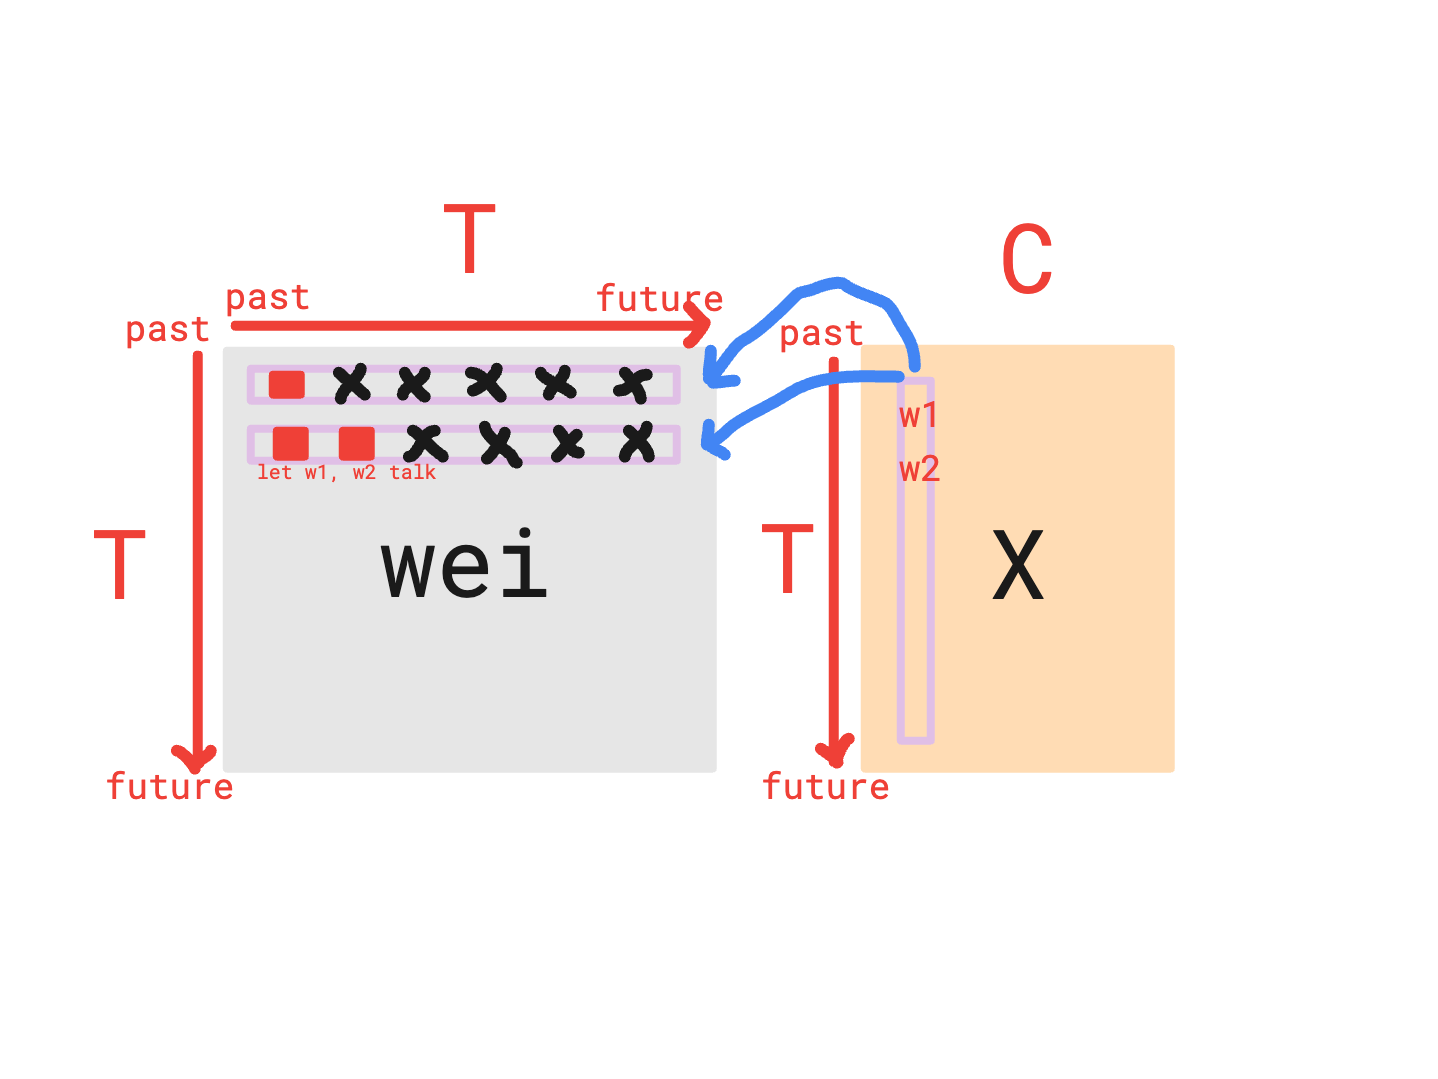

In [ ]:
# wei = A, x = B
tril = torch.tril(torch.ones(T, T))
wei = torch.zeros((T, T))
# For every position in wei, if its corresponding cell in tril==0, replace this cell in wei with -inf.
wei = wei.masked_fill(tril==0, float('-inf')) # fill every tril cell == 0 with -inf. wei now only has 2 values: 0 and -inf
wei = F.softmax(wei, dim=-1) # apply softmax along the last dim which in the case of wei is dim=1 aka along each row
xbow3 = wei @ x
torch.allclose(xbow, xbow3, atol=1e-07) # check if xbow3 get the correct values

True

## Improve Using The Trick: bigram_v2.py [00:58:28]
1. Take out `vocab_size` as input arg of `BigramLanguageModel`, making it global variable.
2. Inroduce a new global variable `n_embd =` embedding dimension.
3. In `forward()`, replace `logits` with `tok_emb` in embedding layer.
4. Add a linear layer in the constructor.
5. Add a position embedding layer below token embedding layer and above linear layer. Position embedding layer encodes position info of tokens.

## Crux of Self-Attention [1:02:00]


### Pytorch Recap
- `nn.Linear(input_size, output_size, bias)`: 线性变换层 (linear transformation layer)
- 生成 $y=xW^T+b$ 中的 $W$ (weight) 和 $b$ (if `bias=True`)
- 实验:
```
m = nn.Linear(20, 128) // bias default True
print(m.weight.size()) // torch.Size([128, 20])
```
- 通过实验, 我们发现, Pytorch会在内部进行维度变换, 即, output_size先于input_size
- 一开始接触时, Pytorch在内部进行的维度变换可能会有点迷惑: 如果`x=BxTxC`, 那么我们应该认为:
    1. `W=Cx16`还是`W=16xC`? `16xC` (`output x input`)
    2. `nn.Linear(C,16).weight`表示的是$W$还是$W^T$? $W$
- 但其实, 并不需要mentally想象Pytorch怎么实现的矩阵相乘: $xW^T$. 只需要明确 data `x`的输入维度(需要消掉的维度)是多少, `nn.Linear()`第一个arg保证与`x`相消的维度保持一致, 第二个arg表示想要的输出维度就可以了。
    - 硬要细究的话, `(input,output)=`$W^T$, `m=nn.Linear(input,output)=`$W$, 而`m(x) = x @ (input,output)`
- `bias=False`的含义: 如果不包含bias, 线性层就是简单的matrix multiplication with fixed some weights.

### Self-Attention Mechanism Explanation
1. Notice that `wei = torch.zeros((T, T))`, meaning that each token/row is initialized uniformly so that `wei @ x` is just the simple average of each row. However, we don't want `wei` to be uniform at all times because some tokens may find other tokens more or less interesting depending on the data `x`.
    - e.g. a vowel may find a consonant interesting. Thus, it wants to know what those consonants are and has these information flow to it.
2. Self-attention solves this problem: **"How to gather information from the past in a data dependent way?"**
3. Solution:
    1. Every single token/node at each position will emit two vectors: `query`, `key`.
        - `query`: "what am I looking for?"
        - `key`: "what do I contain?"
            - information in `key` (values represented in `key`) can mean: "I am a consonant", "I'm in X-th poisition", etc.
    2. The way to get raw affinities between these tokens = `query @ key`
        - (my query) `@` (other tokens' keys) = `wei`
        - if a key and a query are aligned, they will interact to a high amount, meaning that I (row i), as the current token, get to learn more from this specific token (col j) than anyone else.
        - when a cell `wei[k][i][j]` has high affinity, then through softmax, I (row i) will end up aggregating a lot of its (col j) information into my position, meaning that I get to learn a lot about it.
        - The affinity is also called as **"attention score"**.
    3. Let `wei` go through **softmax** to have a distribution summing up to 1. This is telling us that in a data-dependent manner, how much of information to aggregate from any of these tokens in the past.
    4. We DON'T simply use `softmax(wei) @ x`. Instead, we create a `value` vector (same shape as `query` and `key`). `value`同`query` and `key`一样, 也是线性变换层。
        - Replace raw `x` with `v = value(x)`. Then, `softmax(wei) @ v`.
        - `x` = private information to this token. So `x` is private to this token. All information of one token is kept in vector `x`.
        - `value(x)` = encoded actual content of `x`. The thing that gets aggregated for the purpose of this single head between different tokens/nodes.
4. The Party Example - Explaining `query`, `key`, `value` to Non-expert:
    - Situation: Imagine you're at a crowded party ("data ocean"), trying to listen to a friend's story amidst numerous conversations happening around you. In this scenario:
    - Who am I? "You" = `single head`.
    - `query`: **Your Interest or Focus**. Represent your interest or focus at any given moment. When you're trying to follow your friend's story, your "query" is the specific part of the story or the context you're currently focusing on. It's like asking, "What parts of all these conversations are most relevant to the story I'm trying to follow?" 表示你目前的注意力是什么, 在哪里, 关注的是什么主题的“声音”？
    - `key`: **Topic of Each Conversation**. Represent the contextual cues or topics of all the conversations happening around you. Each conversation has a "key" that signifies what it's about. Your brain uses these keys to determine which conversations are relevant to the story you're interested in. 线索暗示你周围的所有这些“声音”是什么主题的。
    - `value`: **Actual Content of Each Conversation**. Represent the actual content of the conversations. Once your brain decides which conversations are relevant (based on the keys), the "values" are the details or the substance of those conversations that you actually listen to and process to understand the story. 每种主题的"声音"它具体的内容是什么。
    - `wei = query @ key`: Measuring the similarity or relevance between what you're interested in and each of the conversations happening around you. In practical terms, this is like your brain automatically evaluating which conversations are worth listening to more closely based on how closely they match what you're currently interested in or thinking about. 就好像每种主题的“声音”都在朝你喊: “我有关! 听我的故事!” 但每种“声音”的音量依据你的兴趣点而有大有小, 这个“分贝”由`query @ key`表示。显然, 越大的"分贝"越容易引起你的注意。
    - `softmax(wei)`: These scores represent the proportion of attention (or focus) that each conversation (input piece) gets. In the party context, this would be akin to deciding how much of your attention to allocate to each conversation based on its relevance to your interest.

In [ ]:
# version 4: self-attention!
torch.manual_seed(1337)
B, T, C = 4, 8, 32 # batch, time, channels
x = torch.randn(B,T,C)

# let's see a single Head perform self-attention
head_size = 16 # head_size is a hyperparam
key = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size, bias=False)
value = nn.Linear(C, head_size, bias=False)
'''
让x穿过矩阵线性变换key/query意味着:
 1. All tokens in (B x T) arrangement in parallel and independently produce a key vector (size=16) and a query vector (size=16)
 2. NO communication happened yet!
 3. 简单理解: 线性转换就是把x中的Channel维度大小变成head_size大小, 就是简单地改变了C维度, 把每个token在C维度上的信息独立地压缩成head_size大小
'''
k = key(x)   # (B, T, 16)
q = query(x) # (B, T, 16)
'''
Communication happens here!
Extract affinities between tokens by dot product key and query
1. key的信息(size=16)对着query的信息(size=16), 合在一起(点积)变成表示两个token之间affinitiy的值 (感觉有点像correlation), 把它用作weights
2. 注意! communicaton only happens within a batch! batch与batch之间是没有交流的, 所以 weights between batches are data-independent
'''
# k.transpose(-2, -1) = transpose k's last two dims
wei = q @ k.transpose(-2, -1) # (B, T, 16) @ (B, 16, T) => (B, T, T)
'''
举个例子:
wei[0][i][j] := In batch 0, how interested of token i is in token j a.k.a raw affinities/interactions between all token pairs.
By 'raw', we mean that wei has gone through masked_fill & softmax yet.
e.g. wei[0][7][3] 如果是一个相对较大的值, 表示8号位子token(t=8)觉得4号位子(t=4)token很有趣, 他俩组cp的可能性很高
注意! 某一token只能看到截止到它当前时间线的tokens(i.e. i>=j). 当i<j, wei=0.00000
'''

tril = torch.tril(torch.ones(T, T))
# wei = torch.zeros((T, T)) # we use key @ query to replace it so that instead of uniform weights, we have data-dependent weights
wei = wei.masked_fill(tril==0, float('-inf')) # mask out with -inf so that upper triangular portion is not observable
wei = F.softmax(wei, dim=-1) # normalization to have distribution sums up to 1.
# out = wei @ x
v = value(x) # (B, T, 16)
out = wei @ v # (B, T, T) @ (B, T, 16) => (B, T, 16)

out.shape

NameError: name 'torch' is not defined